In [27]:
import struct
import numpy as np
import torch
from abc import ABC, abstractmethod
from typing import List
import cv2
from scipy import ndimage

def _read_idx_header(f):
    magic = f.read(2)
    if magic != b'\x00\x00':
        raise ValueError("Not a valid IDX file (wrong magic number)")

    data_type = struct.unpack('>B', f.read(1))[0]
    ndim = struct.unpack('>B', f.read(1))[0]

    dtype_map = {
        0x08: np.uint8,
        0x09: np.int8,
        0x0B: np.int16,
        0x0C: np.int32,
        0x0D: np.float32,
        0x0E: np.float64,
    }

    if data_type not in dtype_map:
        raise ValueError(f"Unsupported IDX data type: {hex(data_type)}")

    shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(ndim))
    return dtype_map[data_type], shape


def read_images_idx(path: str) -> np.ndarray:
    with open(path, 'rb') as f:
        dtype, shape = _read_idx_header(f)

        if len(shape) != 3:
            raise ValueError(f"Expected 3D IDX for images, got shape {shape}")

        data = np.frombuffer(f.read(), dtype=dtype)
        images = data.reshape(shape)

    return images


def read_labels_idx(path: str) -> np.ndarray:
    with open(path, 'rb') as f:
        dtype, shape = _read_idx_header(f)

        if len(shape) != 1:
            raise ValueError(f"Expected 1D IDX for labels, got shape {shape}")

        data = np.frombuffer(f.read(), dtype=dtype)
        labels = data.reshape(shape)

    return labels

In [28]:
X_train_raw = read_images_idx('../data/train-images.idx3-ubyte')
y_train_raw = read_labels_idx('../data/train-labels.idx1-ubyte')

X_test_raw = read_images_idx('../data/t10k-images.idx3-ubyte')
y_test_raw = read_labels_idx('../data/t10k-labels.idx1-ubyte')

print(X_train_raw.shape, X_train_raw.dtype)
print(y_train_raw.shape, y_train_raw.dtype)

(60000, 28, 28) uint8
(60000,) uint8


In [29]:
def normalize_uint8(x: np.ndarray) -> np.ndarray:
    return x.astype(np.float32) / 255.0

def preprocess_mlp(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32) / 255.0
    x = x.reshape(x.shape[0], -1)
    return x

X_train_full = preprocess_mlp(X_train_raw)
X_test = preprocess_mlp(X_test_raw)

y_train_full = y_train_raw
y_test = y_test_raw

print(X_train_full.shape, X_train_full.dtype)
print(X_test.shape, X_test.dtype)

(60000, 784) float32
(10000, 784) float32


In [30]:
import numpy as np

def train_val_split(
    X: np.ndarray,
    y: np.ndarray,
    train_size: int = 55_000,
    shuffle: bool = True,
    seed: int = 42,
):
    assert len(X) == len(y), "X and y must have same length"
    assert train_size < len(X), "train_size must be < N"

    N = len(X)

    indices = np.arange(N)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

    train_idx = indices[:train_size]
    val_idx   = indices[train_size:]

    return (
        X[train_idx],
        y[train_idx],
        X[val_idx],
        y[val_idx],
    )

In [31]:
X_train, y_train, X_val, y_val = train_val_split(
    X_train_full,
    y_train_full,
    train_size=55_000
)

print(X_train.shape, X_val.shape)

(55000, 784) (5000, 784)


In [ ]:
def augment_mnist(img01: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    img = img01.astype(np.float32)

    angle = rng.uniform(-15.0, 15.0)
    scale = rng.uniform(0.9, 1.1)
    tx = rng.integers(-3, 4)
    ty = rng.integers(-3, 4)

    M = cv2.getRotationMatrix2D((14, 14), angle, scale)
    M[0, 2] += tx
    M[1, 2] += ty

    img = cv2.warpAffine(img, M, (28, 28), flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_CONSTANT, borderValue=0.0)

    # thickness: +-1px
    if rng.random() < 0.5:
        k = np.ones((3, 3), np.uint8)
        u8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        u8 = cv2.dilate(u8, k, 1) if rng.random() < 0.5 else cv2.erode(u8, k, 1)
        img = u8.astype(np.float32) / 255.0

    img = random_erasing(img, rng, p=0.2, size=(4, 6))

    # blur
    sigma = rng.uniform(0.0, 0.8)
    if sigma > 1e-6:
        ksize = 3 if sigma < 0.5 else 5
        img = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    # noise
    noise_std = rng.uniform(0.02, 0.05)
    img = img + rng.normal(0.0, noise_std, size=img.shape).astype(np.float32)

    return np.clip(img, 0.0, 1.0)

def random_erasing(img, rng, p=0.2, size=(4, 6)):
    if rng.random() > p:
        return img

    h, w = img.shape
    erase_size = rng.integers(size[0], size[1] + 1)

    y = rng.integers(0, h - erase_size + 1)
    x = rng.integers(0, w - erase_size + 1)

    img = img.copy()
    img[y:y+erase_size, x:x+erase_size] = 0  # чёрный квадрат
    return img


In [33]:
class DataLoader:
    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        shuffle: bool = True,
        seed: int = 42,
        device: str | None = None,
        augment: bool = False,
        is_flat: bool = True,
    ):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.device = device

        self.augment = augment
        self.is_flat = is_flat

        self.N = len(X)
        self.indices = np.arange(self.N)

        if self.augment and self.is_flat:
            raise ValueError("augment=True требует is_flat=False (нужны изображения 28x28 для аугментаций).")

    def __iter__(self):
        self.rng = np.random.default_rng(self.seed)  # один rng на эпоху
        if self.shuffle:
            self.rng.shuffle(self.indices)
        self.pos = 0
        return self

    def __next__(self):
        if self.pos >= self.N:
            raise StopIteration

        idx = self.indices[self.pos : self.pos + self.batch_size]
        self.pos += self.batch_size

        x = self.X[idx]

        if self.augment:
            x_img = x[:, 0] if x.ndim == 4 else x
            x_img = np.stack([augment_mnist(x_img[i], self.rng) for i in range(x_img.shape[0])], axis=0)
            x = x_img.reshape(x_img.shape[0], -1)

        if (not self.augment) and (not self.is_flat):
            if x.ndim == 4:
                x = x[:, 0].reshape(x.shape[0], -1)
            else:
                x = x.reshape(x.shape[0], -1)

        x = torch.from_numpy(x).float().to(self.device)
        y = torch.from_numpy(self.y[idx]).long().to(self.device)

        return x, y



In [34]:
train_loader = DataLoader(
    X_train,
    y_train,
    batch_size=128,
    shuffle=True,
    seed=42
)

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 784]) torch.Size([128])


In [35]:

class Parameter:
    def __init__(self, data: torch.Tensor):
        self.data = data
        self.grad = torch.zeros_like(data)

    def zero_grad(self):
        self.grad.zero_()

    def to(self, device: torch.device):
        self.data = self.data.to(device)
        self.grad = self.grad.to(device)
        return self

In [36]:
class Layer(ABC):
    @abstractmethod
    def forward(self, x: torch.Tensor, train: bool) -> torch.Tensor:
        pass

    @abstractmethod
    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        pass

    def params(self) -> List:
        return []

In [37]:
import torch
from typing import Tuple


class Flatten(Layer):
    def forward(self, x: torch.Tensor, train: bool) -> torch.Tensor:
        self.input_shape: Tuple[int, ...] = x.shape
        return x.view(x.shape[0], -1)

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        return dout.view(self.input_shape)


In [38]:
import torch
import math
from typing import List


class Linear(Layer):
    def __init__(self, in_features: int, out_features: int, device=None):
        if device is None:
            device = torch.device("cpu")

        std = math.sqrt(2.0 / in_features)
        W = torch.randn(in_features, out_features, device=device) * std
        b = torch.zeros(out_features, device=device)

        self.W = Parameter(W)
        self.b = Parameter(b)

        self.x = None

    def forward(self, x: torch.Tensor, train: bool) -> torch.Tensor:
        self.x = x  # cache input
        return x @ self.W.data + self.b.data

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        self.W.grad += self.x.t() @ dout
        self.b.grad += dout.sum(dim=0)

        dx = dout @ self.W.data.t()

        return dx

    def params(self) -> List[Parameter]:
        return [self.W, self.b]

In [39]:
import torch


class ReLU(Layer):
    def forward(self, x: torch.Tensor, train: bool) -> torch.Tensor:
        self.mask = x > 0
        return x * self.mask

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        return dout * self.mask


In [40]:
import torch


class Dropout(Layer):
    def __init__(self, p: float):
        if not (0.0 <= p < 1.0):
            raise ValueError("Dropout probability p must be in [0, 1)")
        self.p = p
        self.mask = None

    def forward(self, x: torch.Tensor, train: bool) -> torch.Tensor:
        if not train or self.p == 0.0:
            return x

        keep_prob = 1.0 - self.p
        self.mask = (torch.rand_like(x) < keep_prob)
        return x * self.mask / keep_prob

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        if self.mask is None:
            return dout
        return dout * self.mask / (1.0 - self.p)

In [41]:
x = torch.ones(10, 5)
drop = Dropout(p=0.5)

out_train = drop.forward(x, train=True)
print(out_train.mean())  # ~1.0 (в среднем)

dout = torch.ones_like(out_train)
dx = drop.backward(dout)

out_eval = drop.forward(x, train=False)
print(torch.allclose(out_eval, x))  # True


tensor(1.1600)
True


In [42]:
import torch


class CrossEntropyLoss:
    def __init__(self):
        self.probs = None
        self.y = None
        self.batch_size = None

    def forward(self, logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        logits_stable = logits - logits.max(dim=1, keepdim=True).values
        exp_logits = torch.exp(logits_stable)
        probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)

        self.probs = probs
        self.y = y
        self.batch_size = logits.shape[0]

        log_probs = torch.log(probs + 1e-12)
        loss = -log_probs[torch.arange(self.batch_size), y].mean()

        return loss

    def backward(self) -> torch.Tensor:
        dlogits = self.probs.clone()
        dlogits[torch.arange(self.batch_size), self.y] -= 1.0
        dlogits /= self.batch_size
        return dlogits

def accuracy(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

In [43]:
class NoOpScheduler:
    def step(self, val_loss):
        pass

class NoOpEarlyStopping:
    def __init__(self):
        self.should_stop = False

    def step(self, value, model):
        pass

    def restore_best_weights(self, model):
        pass

In [44]:
class ReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.3, patience=2, min_lr=1e-6):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr

        self.best = float("inf")
        self.num_bad_epochs = 0

    def step(self, val_loss):
        if val_loss < self.best:
            self.best = val_loss
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            new_lr = max(self.optimizer.lr * self.factor, self.min_lr)
            if new_lr < self.optimizer.lr:
                self.optimizer.lr = new_lr
            self.num_bad_epochs = 0

In [45]:
class EarlyStopping:
    def __init__(self, patience=6, mode="min"):
        self.patience = patience
        self.mode = mode

        self.best = float("inf") if mode == "min" else -float("inf")
        self.counter = 0
        self.best_state = None
        self.should_stop = False

    def step(self, value, model):
        improved = (
            value < self.best if self.mode == "min"
            else value > self.best
        )

        if improved:
            self.best = value
            self.counter = 0
            self.best_state = [
                p.data.clone() for p in model.params()
            ]
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

    def restore_best_weights(self, model):
        for p, best_p in zip(model.params(), self.best_state):
            p.data.copy_(best_p)

In [46]:
logits = torch.tensor([[2.0, 1.0, 0.1]])
y = torch.tensor([0])

criterion = CrossEntropyLoss()
loss = criterion.forward(logits, y)
dlogits = criterion.backward()

print(loss.item())
print(dlogits)

0.4170299768447876
tensor([[-0.3410,  0.2424,  0.0986]])


In [47]:
class Adam:
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.0
    ):
        self.params = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = {}
        self.v = {}
        self.t = 0

        for p in self.params:
            self.m[p] = torch.zeros_like(p.data)
            self.v[p] = torch.zeros_like(p.data)

    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

    def step(self):
        self.t += 1

        for p in self.params:
            if p.grad is None:
                continue

            grad = p.grad

            if self.weight_decay > 0 and p.data.ndim > 1:
                grad = grad + self.weight_decay * p.data

            self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * grad
            self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * (grad * grad)

            m_hat = self.m[p] / (1 - self.beta1 ** self.t)
            v_hat = self.v[p] / (1 - self.beta2 ** self.t)

            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


In [48]:
from typing import List
import torch


class Sequential:
    def __init__(self, layers: List[Layer]):
        self.layers = layers

    def forward(self, x: torch.Tensor, train: bool) -> torch.Tensor:
        for layer in self.layers:
            x = layer.forward(x, train)
        return x

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def params(self):
        params = []
        for layer in self.layers:
            params.extend(layer.params())
        return params
    
    def to(self, device):
        for p in self.params():
            p.to(device)
        return self

In [49]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs: int,
    scheduler,
    early_stopping
):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(epochs):
        model_loss = 0.0
        model_acc = 0.0
        n_batches = 0

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()

            # forward
            logits = model.forward(x_batch, train=True)
            loss = criterion.forward(logits, y_batch)

            # backward
            dlogits = criterion.backward()
            model.backward(dlogits)

            # update
            optimizer.step()

            model_loss += loss.item()
            model_acc += accuracy(logits, y_batch)
            n_batches += 1

        train_loss = model_loss / n_batches
        train_acc = model_acc / n_batches

        val_loss = 0.0
        val_acc = 0.0
        n_batches = 0

        for x_batch, y_batch in val_loader:
            logits = model.forward(x_batch, train=False)
            loss = criterion.forward(logits, y_batch)

            val_loss += loss.item()
            val_acc += accuracy(logits, y_batch)
            n_batches += 1

        val_loss /= n_batches
        val_acc /= n_batches





        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1:03d} | "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
        )

        scheduler.step(val_loss)
        early_stopping.step(val_loss, model)

        print(f"lr = {optimizer.lr:.2e}")

        if early_stopping.should_stop:
            print("Early stopping triggered")
            early_stopping.restore_best_weights(model)
            break

    return history

In [50]:
def build_model_A(device):
    # Baseline
    return Sequential([
        Flatten(),
        Linear(784, 10),
    ]).to(device)


def build_model_B(device):
    # Simple MLP
    return Sequential([
        Flatten(),
        Linear(784, 128),
        ReLU(),
        Linear(128, 10),
    ]).to(device)


def build_model_C(device):
    # MLP + Dropout
    return Sequential([
        Flatten(),
        Linear(784, 256),
        ReLU(),
        Dropout(0.2),
        Linear(256, 10),
    ]).to(device)


def build_model_D(device):
    # Deeper MLP
    return Sequential([
        Flatten(),
        Linear(784, 512),
        ReLU(),
        Linear(512, 256),
        ReLU(),
        Dropout(0.3),
        Linear(256, 10),
    ]).to(device)


In [51]:
EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-3
WD = 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    device=device,
)

val_loader = DataLoader(
    X_val,
    y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    device=device,
)


In [52]:
experiments = {
    "Model A (Baseline)": build_model_A,
    "Model B (MLP)": build_model_B,
    "Model C (MLP + Dropout)": build_model_C,
    "Model D (Deep MLP)": build_model_D,
}

histories = {}
trained_models = {}

for name, builder in experiments.items():
    print(f"\n=== Training {name} ===")

    model = builder(device)
    optimizer = Adam(model.params(), lr=LR, weight_decay=WD)
    criterion = CrossEntropyLoss()

    scheduler = NoOpScheduler()
    early_stopping = NoOpEarlyStopping()

    history = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        epochs=EPOCHS,
        scheduler=scheduler,
        early_stopping=early_stopping
    )

    histories[name] = history
    trained_models[name] = model


=== Training Model A (Baseline) ===


Epoch 001 | train_loss=0.7114, train_acc=0.8216 | val_loss=0.4007, val_acc=0.8990
lr = 1.00e-03
Epoch 002 | train_loss=0.3738, train_acc=0.8992 | val_loss=0.3236, val_acc=0.9195
lr = 1.00e-03
Epoch 003 | train_loss=0.3272, train_acc=0.9103 | val_loss=0.2967, val_acc=0.9236
lr = 1.00e-03
Epoch 004 | train_loss=0.3061, train_acc=0.9154 | val_loss=0.2829, val_acc=0.9260
lr = 1.00e-03
Epoch 005 | train_loss=0.2929, train_acc=0.9186 | val_loss=0.2750, val_acc=0.9289
lr = 1.00e-03
Epoch 006 | train_loss=0.2838, train_acc=0.9208 | val_loss=0.2678, val_acc=0.9291
lr = 1.00e-03
Epoch 007 | train_loss=0.2775, train_acc=0.9230 | val_loss=0.2657, val_acc=0.9307
lr = 1.00e-03
Epoch 008 | train_loss=0.2725, train_acc=0.9236 | val_loss=0.2644, val_acc=0.9303
lr = 1.00e-03
Epoch 009 | train_loss=0.2687, train_acc=0.9253 | val_loss=0.2588, val_acc=0.9320
lr = 1.00e-03
Epoch 010 | train_loss=0.2651, train_acc=0.9257 | val_loss=0.2576, val_acc=0.9322
lr = 1.00e-03
Epoch 011 | train_loss=0.2622, train_acc

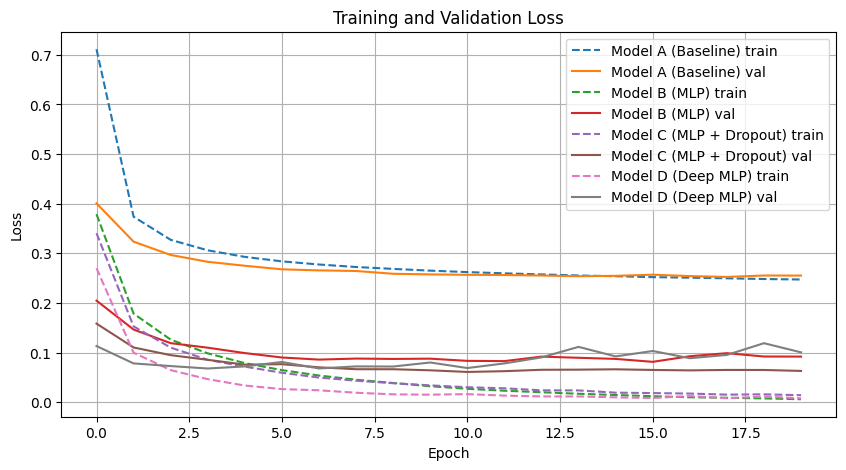

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for name, h in histories.items():
    plt.plot(h["train_loss"], linestyle="--", label=f"{name} train")
    plt.plot(h["val_loss"], linestyle="-", label=f"{name} val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


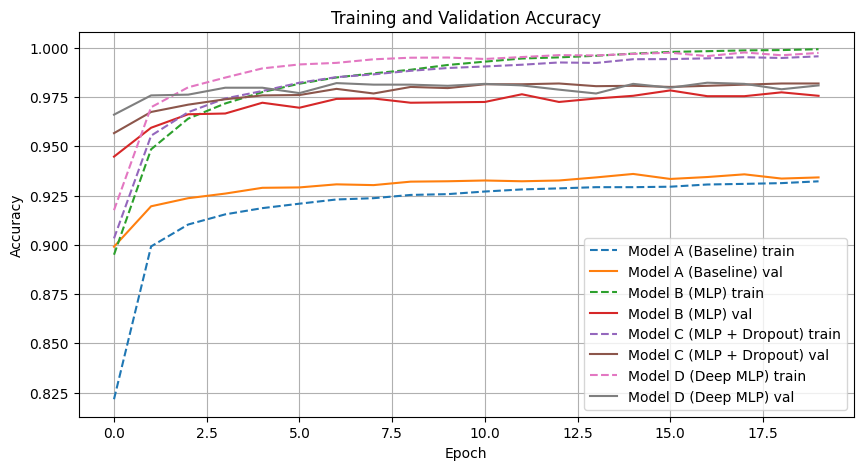

In [54]:
plt.figure(figsize=(10, 5))

for name, h in histories.items():
    plt.plot(h["train_acc"], linestyle="--", label=f"{name} train")
    plt.plot(h["val_acc"], linestyle="-", label=f"{name} val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
X_train_img01 = X_train_raw.astype(np.float32) / 255.0
X_val_img01   = X_val.astype(np.float32) / 255.0

In [57]:
EPOCHS = 50
WD=1e-4

histories_stable = {}
trained_models_stable = {}
# --- Train/Val split (55k/5k) ОДИНАКОВЫМИ индексами ---
seed = 42
N = X_train_raw.shape[0]
rng = np.random.default_rng(seed)
perm = rng.permutation(N)

train_idx = perm[:55_000]
val_idx   = perm[55_000:]

# raw uint8 (N,28,28)
X_train_raw_split = X_train_raw[train_idx]
y_train = y_train_raw[train_idx]

X_val_raw_split = X_train_raw[val_idx]
y_val = y_train_raw[val_idx]

# float32 [0..1] (для аугментаций)
X_train_img01 = X_train_raw_split.astype(np.float32) / 255.0   # (55000,28,28)
X_val_img01   = X_val_raw_split.astype(np.float32) / 255.0     # (5000,28,28)

print("train:", X_train_img01.shape, y_train.shape)
print("val:  ", X_val_img01.shape, y_val.shape)


train: (55000, 28, 28) (55000,)
val:   (5000, 28, 28) (5000,)


In [58]:
train_loader_aug = DataLoader(
    X_train_img01, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    device=device,
    augment=True,
    is_flat=False
)

val_loader_noaug = DataLoader(
    X_val_img01, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    device=device,
    augment=False,
    is_flat=False
)

In [59]:
for name, builder in experiments.items():
    print(f"\n=== Training {name} (LR schedule + EarlyStopping) ===")

    model = builder(device)
    optimizer = Adam(model.params(), lr=1e-3)
    criterion = CrossEntropyLoss()

    scheduler = ReduceLROnPlateau(
        optimizer,
        factor=0.3,
        patience=2,
    )

    early_stopping = EarlyStopping(
        patience=6,
        mode="min",
    )

    history = train_model(
        model,
        train_loader_aug,
        val_loader_noaug,
        optimizer,
        criterion,
        epochs=EPOCHS,
        scheduler=scheduler,
        early_stopping=early_stopping,
    )

    histories_stable[name] = history
    trained_models_stable[name] = model


=== Training Model A (Baseline) (LR schedule + EarlyStopping) ===
Epoch 001 | train_loss=1.7137, train_acc=0.4469 | val_loss=1.0301, val_acc=0.6990
lr = 1.00e-03
Epoch 002 | train_loss=1.5583, train_acc=0.5039 | val_loss=0.9891, val_acc=0.7115
lr = 1.00e-03
Epoch 003 | train_loss=1.5428, train_acc=0.5053 | val_loss=0.9928, val_acc=0.7027
lr = 1.00e-03
Epoch 004 | train_loss=1.5264, train_acc=0.5092 | val_loss=1.0177, val_acc=0.6676
lr = 3.00e-04
Epoch 005 | train_loss=1.5287, train_acc=0.5084 | val_loss=1.0137, val_acc=0.6803
lr = 3.00e-04
Epoch 006 | train_loss=1.5288, train_acc=0.5105 | val_loss=1.0107, val_acc=0.6822
lr = 9.00e-05
Epoch 007 | train_loss=1.5214, train_acc=0.5114 | val_loss=1.0025, val_acc=0.6883
lr = 9.00e-05
Epoch 008 | train_loss=1.5237, train_acc=0.5094 | val_loss=1.0032, val_acc=0.6914
lr = 2.70e-05
Early stopping triggered

=== Training Model B (MLP) (LR schedule + EarlyStopping) ===
Epoch 001 | train_loss=1.1879, train_acc=0.6449 | val_loss=0.4129, val_acc=0.8

In [60]:
best_name = None
best_val_acc = -1.0
best_model = None
best_source = None

for name, history in histories.items():
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_name = name
        best_model = trained_models[name]
        best_source = "baseline"

for name, history in histories_stable.items():
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_name = name
        best_model = trained_models_stable[name]
        best_source = "stable"

print(
    f"Best model: {best_name} | "
    f"source={best_source} | "
    f"best val_acc={best_val_acc:.4f}"
)

Best model: Model D (Deep MLP) | source=stable | best val_acc=0.9891


In [61]:
def preprocess_digit(path: str) -> torch.Tensor:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")

    if img.mean() > 127:
        img = 255 - img

    _, img_bin = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    coords = np.column_stack(np.where(img_bin > 0))
    if coords.size == 0:
        raise ValueError("No foreground pixels found")

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    img_crop = img_bin[y_min:y_max + 1, x_min:x_max + 1]

    h, w = img_crop.shape
    size = max(h, w)
    padded = np.zeros((size, size), dtype=np.uint8)

    y_offset = (size - h) // 2
    x_offset = (size - w) // 2
    padded[y_offset:y_offset + h, x_offset:x_offset + w] = img_crop

    img_20 = cv2.resize(padded, (20, 20), interpolation=cv2.INTER_AREA)

    img_28 = np.zeros((28, 28), dtype=np.uint8)
    img_28[4:24, 4:24] = img_20

    cy, cx = ndimage.center_of_mass(img_28)
    if not np.isnan(cx):
        shift_y = int(np.round(14 - cy))
        shift_x = int(np.round(14 - cx))
        img_28 = ndimage.shift(img_28, shift=(shift_y, shift_x), mode="constant")

    img_28 = img_28.astype(np.float32) / 255.0

    x = torch.from_numpy(img_28).unsqueeze(0).unsqueeze(0)

    return x

In [62]:
def show_prediction(model, path, device):
    x = preprocess_digit(path).to(device)

    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    processed = x[0, 0].cpu().numpy()

    logits = model.forward(x, train=False)
    probs = torch.softmax(logits, dim=1)[0]

    topk = torch.topk(probs, k=3)

    plt.figure(figsize=(8, 3))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(raw, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Processed 28x28")
    plt.imshow(processed, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    for i in range(3):
        cls = topk.indices[i].item()
        p = topk.values[i].item()
        plt.text(0.1, 0.8 - i * 0.25, f"{i+1}. {cls}: {p:.3f}", fontsize=12)
    plt.axis("off")

    plt.show()

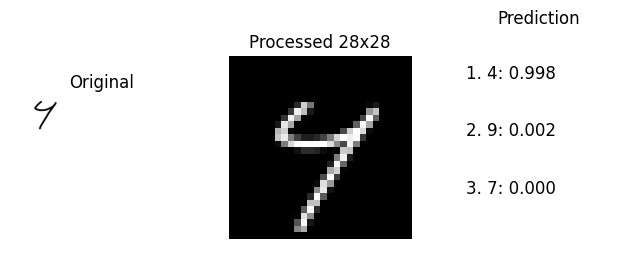

In [67]:
show_prediction(best_model, "digit_paint.png", device)